In [6]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
from read_data import *
from filter import *
from analysis import *
%matplotlib inline
import matplotlib.pyplot as plt
import copy, os 
from model import *
cwd = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model classes

## Initialization of model and application of methods

In [2]:
rec = Recording()
rec.load_data()

In [7]:
rec.data['raw'][0].currentTrace

array([ -1.19479965e-12,  -4.87228004e-12,  -2.44911039e-12, ...,
        -3.22733238e-12,  -1.68614765e-12,  -2.36518448e-12])

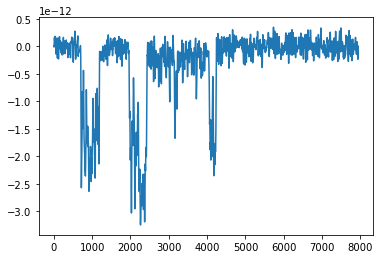

In [95]:
rec.filter_data()
rec.baseline_correction('G1000Hz',[[0,10],[110,200]])
plt.plot(rec.data["G1000Hz_BC"][0].currentTrace[10:-50])

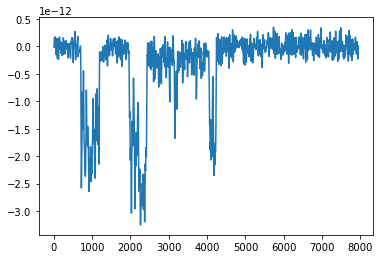

In [107]:
rec.baseline_correction('G1000Hz',[[0,10],[110,200]],method='poly',degree=1)
plt.plot(rec.data["G1000Hz_BC"][0].currentTrace[10:-50])

In [108]:
original = rec.data['raw_BC'][0].currentTrace[10:-50]
signal = rec.data['G1000Hz_BC'][0].currentTrace[10:-50]
time = rec.data['G1000Hz_BC'][0].time[10:-50]

# Functions

## Threshold crossing (multilevel)

In [114]:
def multilevel_threshold(signal,thetas):
    """
    Idealizes a current trace using a threshold crossing algorithm.
    
    Parameters:
        signal [1D array of floats] - the signal to be idealized
        thetas [1D array of floats] - the thresholds seperating the different levels
        
    Returns:
        idealization [1D array of floats] - an array of the same length as `signal` containing the idealization of the trace
        signalmax [float] - the maximum amplitude of the signal
    This method assumes that there are four different conductance states and that their amplitudes are evenly spaced.
    """
    thetas = np.sort(thetas)
    signalmax = np.max(np.abs(signal))
    idealization = np.zeros(len(signal))
    for i in range(len(signal)):
        if thetas[0]<np.abs(signal[i])<thetas[1]:
            idealization[i] = 1/3
        elif thetas[1]<np.abs(signal[i])<thetas[2]:
            idealization[i] = 2/3
        elif thetas[2]<np.abs(signal[i]):
            idealization[i] = 1
    return idealization, signalmax

In [ ]:
ideal, sm = multilevel_threshold(signal,thetas)
masks = []
for i in range(4):
    mask = ideal == i/3 
    masks.append(mask)

In [109]:
x = np.random.random(10)

In [140]:
y = np.zeros_like(x)
l = np.array([0,1/6,1/2,5/6,1])
i = 1
N = len(l)

#this is a threshold crossing function for an arbitrary number of levels
# y is the idealization
# x is the input
# l are the thresholds, 0 and 1 should be added to the list and they should be sort from smallest to largest
for i in range(N):
        y[l[i]<=x] = i/(N-2) #divide by (N-2) since the parameter N actually includes the 0 and the 1
# because of the division above (which defines the relative amplitude of the levels) this only works if the levels are equally spaced

(array([ 0.3914943 ,  0.04001226,  0.78607328,  0.00176545,  0.37535582,
         0.91665514,  0.41304475,  0.62515343,  0.29381966,  0.47299502]),
 array([ 0.33333333,  0.        ,  0.66666667,  0.        ,  0.33333333,
         1.        ,  0.33333333,  0.66666667,  0.33333333,  0.33333333]))

### Demonstration of idealization by thresholdcrossing

[  5.41980182e-13   1.62594055e-12   2.70990091e-12] [  8.12970274e-13   1.62594055e-12   2.43891082e-12]


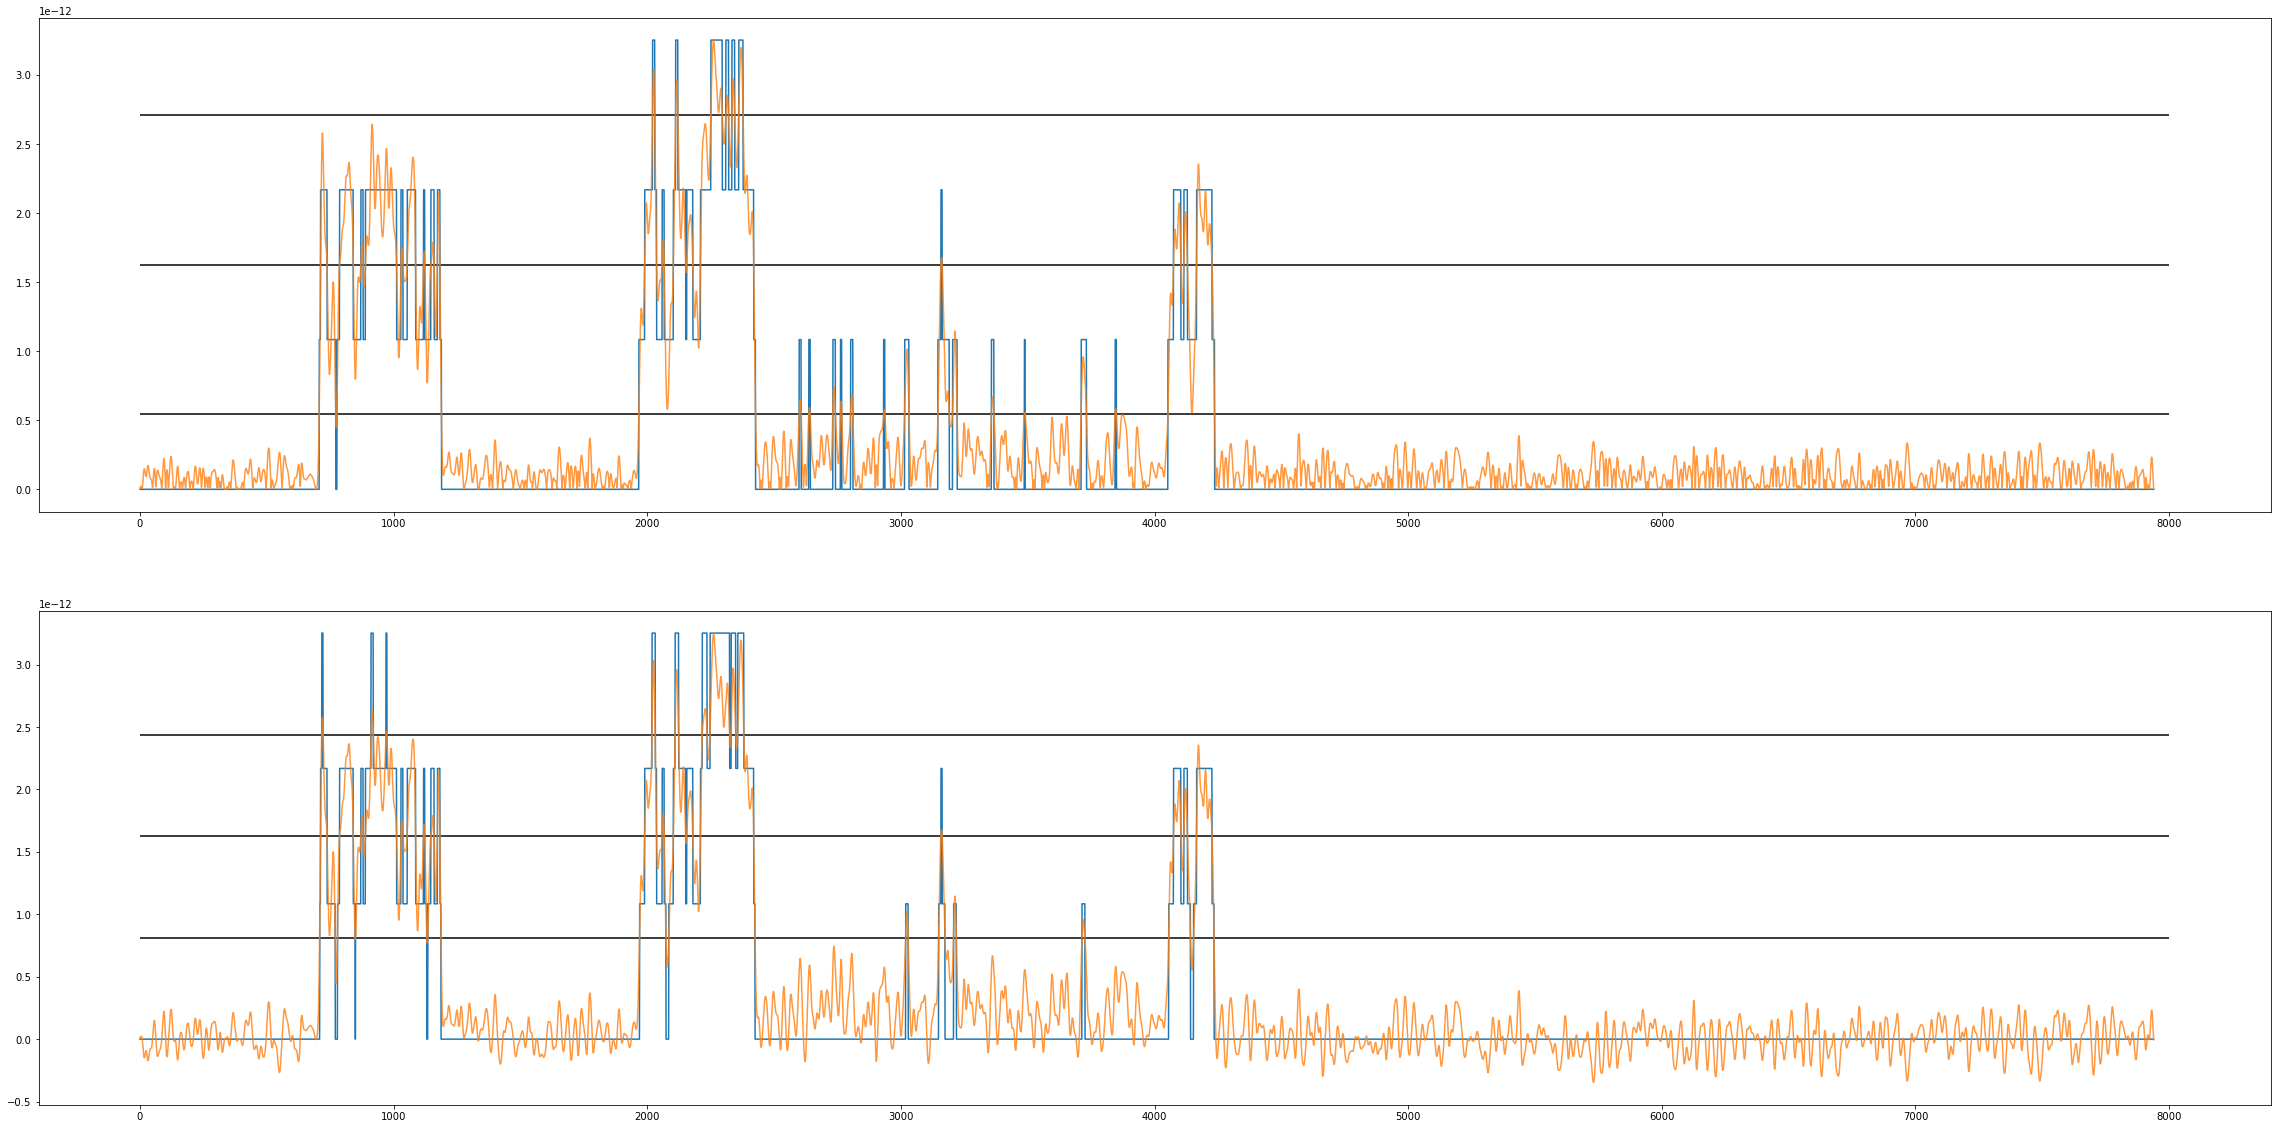

In [116]:
#threshold are halfway between the different levels
ts = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,ts)
plt.figure(figsize=(40,20))
plt.subplot(211)
plt.plot(ideal*sm,alpha = 1)
plt.plot(np.abs(signal),alpha=.8)
for t in ts:
    plt.hlines(t,0,8e3)
    
#thresholds are linearly spaced starting at 0, this is not how they are meant to be but looks quite good so it'll stay here for a bit
thetas = np.linspace(0,1,5)[1:-1]*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)
plt.subplot(212)
plt.plot(ideal*sm,alpha = 1)
plt.plot(-signal,alpha=.8)
for t in thetas:
    plt.hlines(t,0,8e3)
print(ts, thetas)

## Generate noise function

In [11]:
def gen_noise(noise_sd, f_0=300, N = 1e4, type='f'):
    """
    generate noise as in Clements and Bekkers '977
        
    parameters:
        noise_sd [float] - desired standard deviation in the noise 
        f_val [float] - the frequeny below which the noise is approximately white 
        N [int] - desired length of the array 
        type [string] = the type of noise that is to be generated, can be 1+1/f ('f') or 1+1/f^2 ('fsqaured')
    returns:
        noise - 1D array of length N containing the the noise signal
    """
    N = int(N)
    f = np.arange(1,N)
    
    ## ??
    freq_scale = 4e4/N
    f = f * freq_scale    

    realSpectrum = np.random.uniform(-1,1,size=N-1) #random array for real part
    imgSpectrum = np.random.uniform(-1,1,size=N-1) #random array for imaginary part
    
    if type == 'f':
        realSpectrum = realSpectrum*(1+f/f_0)
        imgSpectrum = imgSpectrum*(1+f/f_0)
    elif type == 'fsquared':
        realSpectrum = realSpectrum*(1+(f/f_0)**2)
        imgSpectrum = imgSpectrumi*(1+(f/f_0)**2)
    else:
        print('Unkown noise spectrum type. Generating white noise')
    
    spectrum = realSpectrum+1j*imgSpectrum
    spectrum = np.hstack((0,spectrum))
    power = np.abs(spectrum)**2
    spectrum /= np.sqrt(np.sum(power)) #normalize the power of the spectrum
    noise = noise_sd*np.fft.irfft(spectrum,N)*np.sqrt(np.pi)*N
    ## np.fft.irfft normalizes with 1/N, according to the paper we want noise_std/sqrt(N*Pi) (not sure what normalization their algorithm uses if any)
    ## so we should multiply with N^(1/2) but it works with N (i.e. it generates noise with a standard deviation that 
    ## is the same order of magnitude as the real noise), also if we want the std to be noise_std we should not multiply by pi^(1/2), probably also related
    ## to the normalization in the algorithm that Clements and Bekkers use
    ## using the real fft because there are no negative frequency components in this noise
    return noise

### Add noise to idealization to reconstruct signal

In [110]:
## get the standard deviation from the filtered and unfiltered signal
std = np.zeros(4)
std_original = np.zeros(4)
for i in range(4):
    mask = ideal == i/3 #creates mask to seperate the different activations found during the idealization
    std[i] = np.std(signal[mask])
    std_original[i] = np.std(original[mask])
print(std)
print(std_original)

[  1.54894708e-13   3.45859523e-13   2.83014387e-13   1.50987510e-13]
[  1.37321915e-12   1.62259185e-12   1.67230478e-12   1.69138653e-12]


it is assumed that noise level is independent of the channel state, the numbers above suggest that this might be true for the open states but that the closed state has a lower level of noise

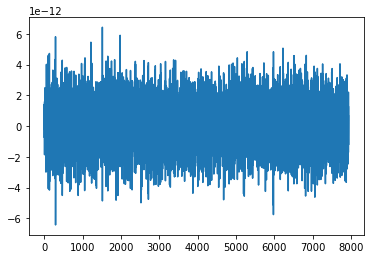

In [86]:
noise = gen_noise(std_original.max(), N=len(ideal), f_0=1e3)
plt.plot(noise);

In [87]:
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)

reconstructed = -sm*ideal+noise

#create standard gaussian filter
fc, fs, = 1e3, 4e4
fcs = fc/fs
window = Gaussian(fcs)

filtered = apply_filter(reconstructed,window)

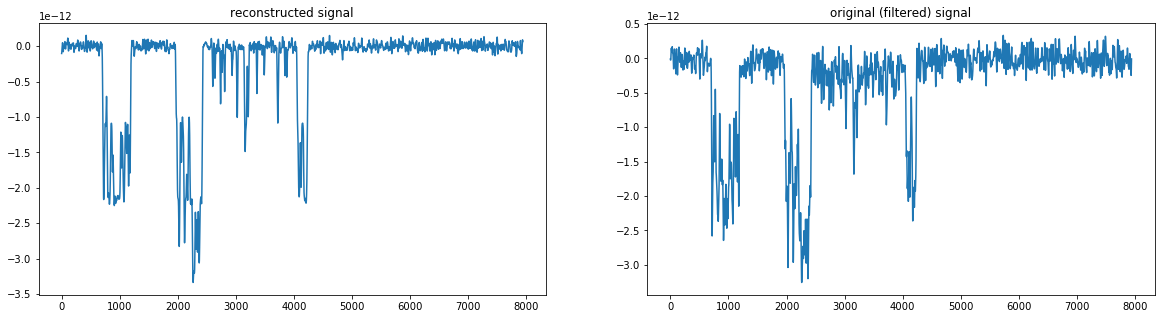

In [88]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(filtered)
plt.title('reconstructed signal')
plt.subplot(122)
plt.plot(signal)
plt.title('original (filtered) signal');

#### Comparison with Andrew's noise simulator

Below is a comparison of the noise generated above and the noise generated with Andrew's function. In order to make this work I had to add a length parameter to the `numpy.fft.irfft` function in `noise_gen.spec_to_noise` as the length would otherwise be $2N-2$ (this is due to something weird in the ifft function and is not what the documentation says should happen).

Scaling....
[-0.00038772 -1.33075484e-05j  0.00046102 -1.09807669e-05j
 -0.00032490 +6.86545864e-05j ...,  0.00159856 -3.24687381e-03j
  0.00702797 -6.29588164e-03j  0.02143125 +2.10281426e-02j] 7940


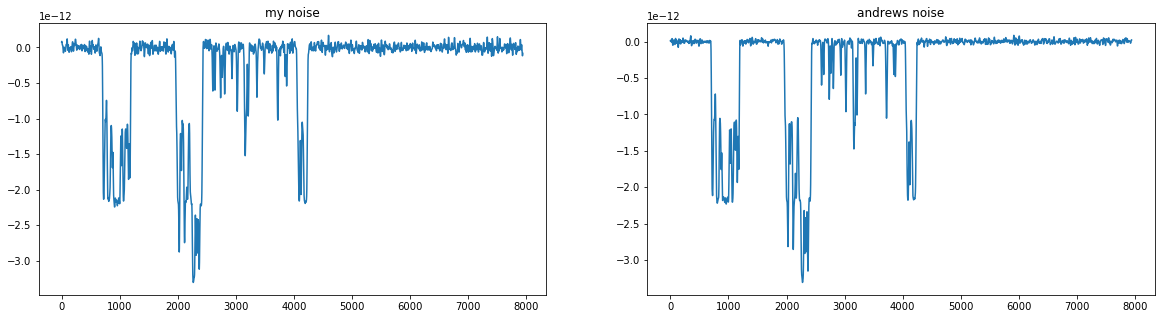

In [89]:
import noise_gen
noise = gen_noise(std_original.mean(), N=len(ideal),f_0 = 1000)
reconstructed = -sm*ideal+noise
filtered = apply_filter(reconstructed,window)
f1, s1 = noise_gen.oneplusf_gen(len(signal), type='1+f');
an = noise_gen.spec_to_noise(s1,1.6e-12);
r = -sm*ideal+an
f = apply_filter(r,window)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(filtered)
plt.title('my noise')
plt.subplot(122)
plt.plot(f)
plt.title('andrews noise');

# Gradient descent curve fitting??

In [111]:
def eval_numerical_gradient(f, x):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00000001
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension
    return grad

In [173]:
def grad(f,x):
    fx = f(x)
    dim = len(x)
    grad = np.zeros(dim)
    h = 1e-1
    for i in range(dim):
        xh = x
        print(h)
        xh[i]+=h
        print(xh)
        fxh = f(xh)
        print(fxh)
        grad[i] = (fxh-fx)/h
        print(grad[i])
    return grad

In [174]:
f = lambda x: np.sum(x)

In [180]:
x = np.array([1.,0.])
y = np.array([1,0])
type(x[0]), type(y[0])

(numpy.float64, numpy.int64)

In [177]:
grad(f,x),eval_numerical_gradient(f,x), 

0.1
[ 1.1  0. ]
1.1
1.0
0.1
[ 1.1  0.1]
1.2
2.0


(array([ 1.,  2.]), array([ 0.99999999,  0.99999999]))

In [91]:
def loss(signal,thetas):
    ideal, sm = multilevel_threshold(signal,thetas)
    difference = np.sum((-sm*ideal+noise-signal)**2)/np.max(np.abs(signal))**2
    return difference

In [92]:
L = loss(signal,oT)

In [93]:
from functools import partial
loss_train = partial(loss, signal)

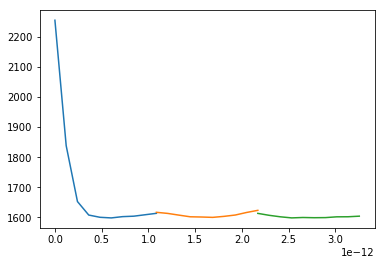

In [94]:
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))

t1 = np.linspace(0,1/3,10)*np.max(np.abs(signal))
t2 = np.linspace(1/3,2/3,10)*np.max(np.abs(signal))
t3 = np.linspace(2/3,1,10)*np.max(np.abs(signal))
l1 = []
l2 = []
l3 = []
for t in t1:
    ts = np.copy(thetas)
    ts[0] = t
    l1.append(loss_train(ts))
for t in t2:
    ts = np.copy(thetas)
    ts[1] = t
    l2.append(loss_train(ts))
for t in t3:
    ts = np.copy(thetas)
    ts[2] = t
    l3.append(loss_train(ts))
plt.plot(t1,l1)
plt.plot(t2,l2)
plt.plot(t3,l3)

In [134]:
oT = np.random.uniform(0,1*np.max(np.abs(signal)),size=3)
oT = np.sort(oT)
# oT = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
dE = 1
eta = 5e-25
l_old = loss_train(oT)
# print(l_old)
i = 0
while dE>1e-20:
#     print('step ',i)
    i+=1
    df = eval_numerical_gradient(loss_train, oT)
#     print('df',df)
    oT-= eta*df
#     print('thetas:', thetas)
    l_new = loss_train(oT)
#     print(l_new)
    dE = np.abs(l_new-l_old)/l_new
#     print(dE)
    l_old = l_new
    eta*=.9
#     print('current dE%.2d'%dE)
print('finished after %.d steps' %i)

finished after 1 steps


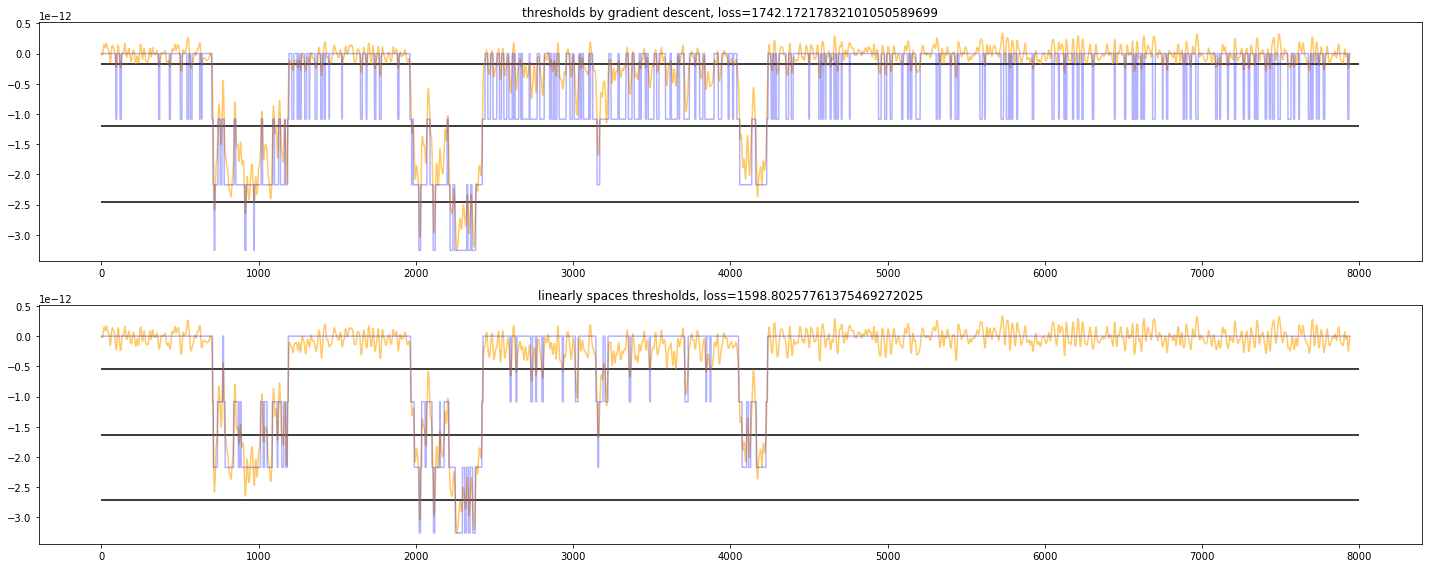

In [117]:
plt.figure(figsize=(20,8))
ideal, sm = multilevel_threshold(signal,oT)
plt.subplot(211)
plt.plot(signal,alpha=.6,c='orange')
plt.plot(-ideal*sm,alpha=.3,c='b')
plt.title('thresholds by gradient descent, loss=%.20f'%loss_train(oT))
for t in oT:
    plt.hlines(-t,0,8e3)

plt.subplot(212)
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)
plt.plot(signal,alpha=.6,c='orange')
plt.plot(-ideal*sm,alpha=.3,c='b')
plt.title('linearly spaces thresholds, loss=%.20f'%loss_train(thetas))
plt.tight_layout()
for t in thetas:
    plt.hlines(-t,0,8e3)

# With simulated data

In [7]:
bn = 'sim1600.bin'
bp = cwd+'/data'
bt = np.int16
bh = 3072
n, t, d = load_binary(bp,bn,bt,bh,4e4)

In [8]:
rec = Recording(filename=bn,filepath=bp,filetype='bin',headerlength=bh,bindtype=bt)
rec.load_data()

In [130]:
def visual_compare(recording, dataKey = 'raw', epochnumber = 0, tstart = 0, tend = 5000):
    """
    This function generates a plot comparing the idealized trace to the original trace
    """
    fig = plt.figure(figsize=(20,8))
    time = recording.data[dataKey][epochnumber].time[tstart:tend]
    signal = recording.data[dataKey][epochnumber].currentTrace[tstart:tend]
    ideal = recording.data[dataKey+'_TC'][epochnumber].currentTrace[tstart:tend]
    plt.plot(time, signal, label='unfiltered data',alpha=.8)
    plt.plot(time, ideal, label='idealization', alpha =.7)
    plt.xlabel('time [ms]')
    plt.xticks(np.arange(tstart,tend))
    plt.ylabel('current [A]')
    plt.show()

In [11]:
rec.filter_data()

dict_keys(['raw', 'G1000Hz'])


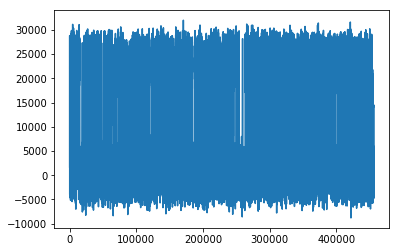

In [19]:
print(rec.data.keys())
plt.plot(rec.data['raw'][0].currentTrace)

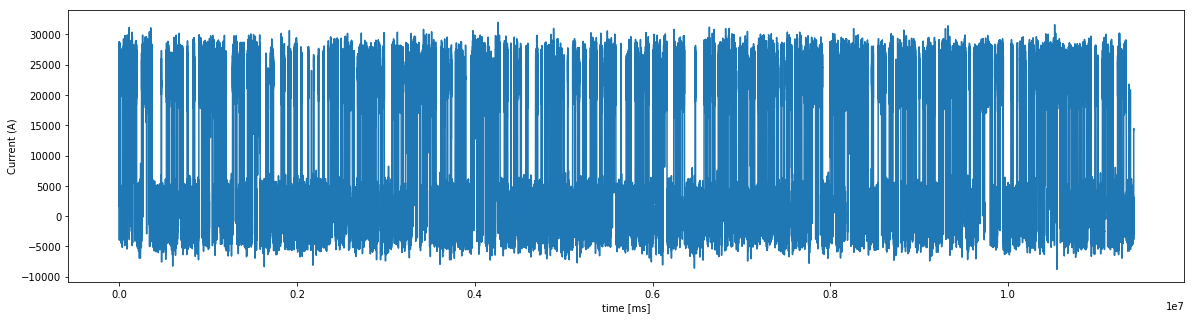

In [20]:
rec.data['raw'][0].plot_trace()